In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from library.dataset import read_csv

DATASET_PATH = 'data/data_kaggle_2021.csv'

# Introduction
The objective of this notebook is to conduct an Exploratory Data Analysis of the dataset [House Pricing in Belo Horizonte](https://www.kaggle.com/datasets/guilherme26/house-pricing-in-belo-horizonte/code) in order to be able to use it to train a predictive model of the real estate pricing in Belo Horizonte.

## Understand the dataset
First of all, let's load the dataset and display basic informations about it.

In [2]:
df = read_csv(DATASET_PATH)
df = df.drop_duplicates()

print(f'The dataset contains {df.shape[0]} distinct rows and {df.shape[1]} columns ({', '.join(df.columns)}.\n')

df.info()

The dataset contains 5981 distinct rows and 10 columns (address, adm-fees, garage-places, price, rooms, square-foot, neighborhood, city, latitude, longitude.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5981 entries, 0 to 5980
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   address        5981 non-null   object 
 1   adm-fees       3977 non-null   float64
 2   garage-places  5981 non-null   object 
 3   price          5951 non-null   float64
 4   rooms          5981 non-null   object 
 5   square-foot    5981 non-null   object 
 6   neighborhood   5957 non-null   object 
 7   city           5981 non-null   object 
 8   latitude       5981 non-null   float64
 9   longitude      5981 non-null   float64
dtypes: float64(4), object(6)
memory usage: 467.4+ KB


First, we will rename the columns to replace the hyphens by underscores.

In [3]:
df.rename(columns={col: col.replace('-', '_') for col in df.columns}, inplace=True)

### Understandig the columns
Acording to the dataset description, the description of the columns is as follow:
- **address (string):** real address from the property
- **adm_fees (float):** fees related to condominium maintenance in Brazilian Reais (BRL)
- **garage_places (string):** quantity of garage slots
- **price (float):** the property price in Brazilian Reais (BRL)
- **rooms (string):** number of rooms in the property
- **square_foot (string):** property square footage
- **neighborhood (string):** the eighborhood in which the property is located
- **city (string):** the city in which the property is located
- **latitude (float):** the latitude of the property
- **longitude (float):** the latitude of the property

#### Geographical variables
We can consider the 5 geographical variables (address, neighborhood, city, latitude, longitude), which are likely to be correlated. A quick look at the dataset overview showed us that `city`, `latitude`, `longitude` have a very low variance since most of the properties of the dataset are located in the city of Belo Horizonte. Since we can consider that the neighborhood is a more precise variable, we'll discard those variables. `address` might be too precise as is but might be interesting once striped of the street number of even categorized by the type of street (stree, avenue, etc.).

#### Property description variables
As we can see, the columns `garage-places`, `rooms` and `square-foot` that should be expected to contain integers values actually contain string values, which will require further investigations.

`adm-fees` contains a lot of `null` values. It isn't known if it means that there a no admin fees or if the data is missing but it might be difficult to use this data.

`price` will be our target value.

Let's start by analyzing the `garage-places`, `rooms` and `square-foot` variables and understand why they aren't numerical.

In [4]:
print(f'Percentage of non numeric values in column garage_places: {round((len(df[df['garage_places'].str.contains('-')]) / len(df)) * 100, 2)}%.')
print(df[df['garage_places'].str.contains('-')]['garage_places'].value_counts(ascending=True))
print(f'Percentage of non numeric values in column rooms: {round((len(df[df['rooms'].str.contains('-')]) / len(df)) * 100, 2)}%.')
print(df[df['rooms'].str.contains('-')]['rooms'].value_counts(ascending=True))
print(f'Percentage of non numeric values in column square-foot: {round((len(df[df['square_foot'].str.contains('-')]) / len(df)) * 100, 2)}%.')
print(df[df['square_foot'].str.contains('-')]['square_foot'].value_counts(ascending=True))

Percentage of non numeric values in column garage_places: 9.71%.
garage_places
2-4      1
1-3      1
1-2      7
3-4      9
2-3     10
--     553
Name: count, dtype: int64
Percentage of non numeric values in column rooms: 8.88%.
rooms
4-5      1
1-2      2
3-4      6
2-3     18
--     504
Name: count, dtype: int64
Percentage of non numeric values in column square-foot: 1.05%.
square_foot
45-65       1
133-160     1
54-74       1
--          1
185-238     1
237-238     1
25-155      1
55-146      1
87-160      1
186-310     1
54-67       1
40-41       1
71-139      1
47-50       1
37-45       1
47-62       1
48-98       1
48-75       1
46-47       1
46-50       1
38-41       1
44-84       1
52-73       1
250-1020    1
41-48       1
73-81       1
145-157     1
82-86       1
60-71       1
62-65       1
39-48       1
66-118      1
66-145      1
87-134      1
76-208      1
103-128     1
64-93       1
84-87       1
92-125      1
50-110      1
47-67       1
65-81       1
66-86       1
74-141  

As we can see, most of the non-numeric values are filled with `--`.
- This might mean no garage space for the `garage_places` column so we will replace it by `0`.
- For the `rooms` and `square_foot` columns, it is likely to refer to commercial spaces, which are likely to be priced in a very different way from residential properties and we will then remove them from the dataset.

Missing value for the `adm_fees` column are likely to refer to properties without a concierge service, hence, most of the time, a house and not an appartment. We will replace them by `0` for the time being.

The other kind of non-numerical values are ranges. I suggest we replace them by the `mean value` of the range.

Finally, we will also clean the `city` and `neighborhood` and remove the rows with remaining missing values.

In [5]:
df['rooms'] = pd.to_numeric(df['rooms'], errors="coerce")
df['square_foot'] = pd.to_numeric(df['square_foot'], errors="coerce")
df['garage_places'].replace(['--', '4-5', '3-4', '1-2', '2-3'], ['0', '5', '4', '2', '3'])
df['garage_places'] = pd.to_numeric(df['garage_places'], errors="coerce")

df.dropna(subset=['rooms', 'square_foot', 'garage_places'], inplace=True)

df['rooms'] = df['rooms'].astype(np.int64)
df['garage_places'] = df['garage_places'].astype(np.int64)

df['adm_fees'] = df['adm_fees'].fillna(0)
df['adm_fees'] = df['adm_fees'].astype(np.int64)

df['city'] = df['city'].astype(str)
df['city'] = df['city'].str.strip()

df['neighborhood'] = df['neighborhood'].astype(str)
df['neighborhood'] = df['neighborhood'].str.strip()

df.dropna(axis=0, inplace=True)

In [6]:
df.head()

,address,adm_fees,garage_places,price,rooms,square_foot,neighborhood,city,latitude,longitude
0,"Avenida Raja Gabaglia, 1583",470,1,330000.0,1,40.0,Luxemburgo,Belo Horizonte,-19.936415,-43.953396
2,"Rua dos Expedicionários, 1082",0,5,1190000.0,4,411.0,Santa Amélia,Belo Horizonte,-20.225241,-44.397780
3,"Rua Marechal Hermes, 81",750,4,1590000.0,4,158.0,Gutierrez,Belo Horizonte,-19.937155,-43.958694
4,"Rua Juruna, 110",0,6,550000.0,3,278.0,Pindorama,Belo Horizonte,-19.912982,-44.019944
5,"Rua Maria Pereira de Araújo, 15",500,1,450000.0,3,87.0,Castelo,Belo Horizonte,-19.886147,-44.004236


### Target variable
The target variable that we will try to predict is the `price` variable.

The price variable is of type `float64` which seems reasonnable and all properties define a price variable.

Let's now analyse the distribution of the prices and eliminate possible outliers.

In [7]:
target_variable = 'price'
df.price.describe(percentiles=[0.01, 0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    5.162000e+03
mean     1.035421e+06
std      1.098414e+06
min      5.500000e+02
1%       5.061000e+03
2%       1.550000e+05
10%      2.760000e+05
25%      4.290000e+05
50%      7.000000e+05
75%      1.234115e+06
90%      2.150450e+06
95%      2.900000e+06
99%      5.900000e+06
max      1.364857e+07
Name: price, dtype: float64

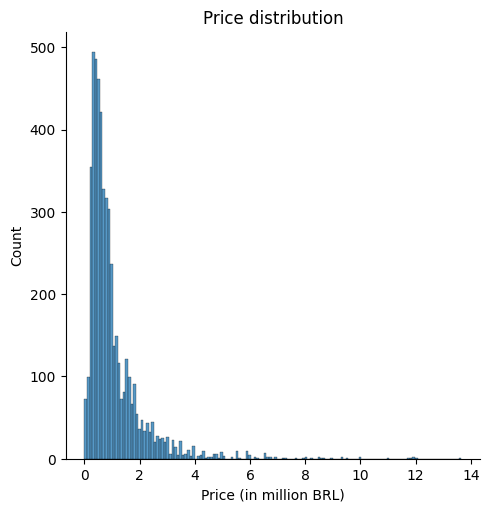

In [8]:
sns.displot(df.price/1e6)
plt.title("Price distribution")
plt.xlabel("Price (in million BRL)")
plt.show()

As we can see, most of the prices are concentrated under 10 millions BRL. However, some outliers have a very high price which are likely not to representative. Since those estates are likely to have very specific pricing, it doesn't make much sense to use them for a general pricing model.

We must also have a look at the lowest values since some of them seems way too low to be a purchase value and might be rent values. 

In consequence, we'll cut the values under R\\$100.000 and over R\\$4 millions.

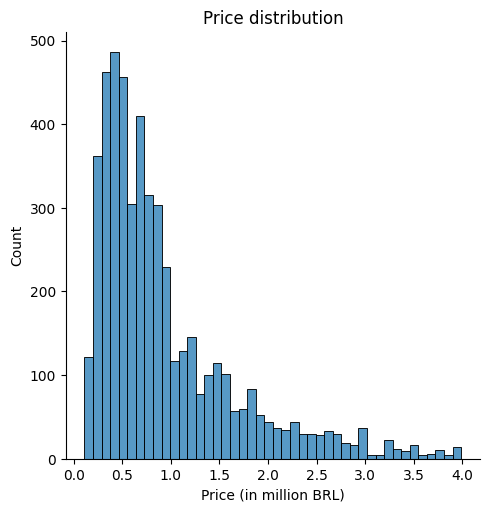

In [9]:
df = df[df.price.between(1e5, 4e6)]

sns.displot(df.price/1e6)
plt.title("Price distribution")
plt.xlabel("Price (in million BRL)")
plt.show()

### Price per square foot
Let's create a `square_foot_price` column. This column will help us normalize the price value to find aberrations.

However, it might not be used as a feature for our model since it requires the variable we try to predict to be computed.

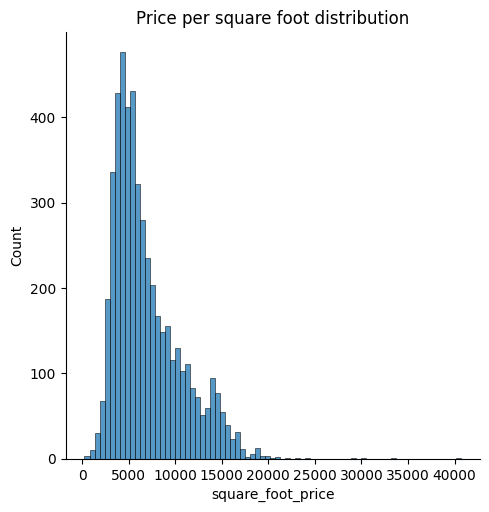

count     4978.000000
mean      6929.783459
std       3671.877653
min        250.000000
0.1%       886.398333
5%        2838.508728
10%       3298.640053
25%       4235.994398
50%       5825.036613
75%       8873.991935
90%      12459.016393
95%      14376.881356
99%      16876.712329
max      40714.285714
Name: square_foot_price, dtype: float64

In [10]:
df['square_foot_price'] = (df['price'] / df['square_foot'])

sns.displot(df['square_foot_price'])
plt.title("Price per square foot distribution")
plt.xlabel
plt.show()

df['square_foot_price'].describe(percentiles=[0.001, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

We can see that we have a few very low but also very high values. In consequence, we will remove the lowest 0,01% percents and the highest 1% percents of the price per square root distribution since they might be aberrations.

In [11]:
df = df[df.square_foot_price.between(df.square_foot_price.quantile(0.01), df.square_foot_price.quantile(0.99))]

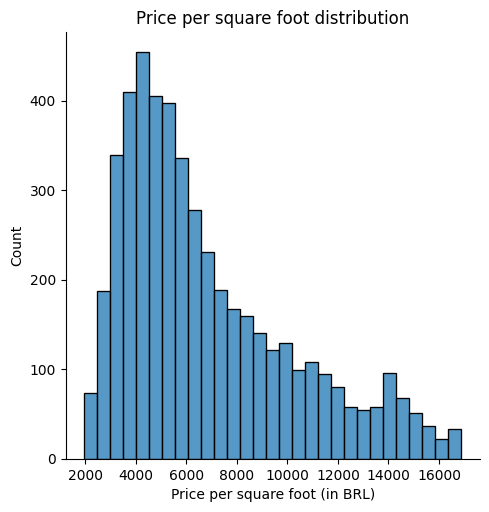

count     4879.000000
mean      6855.172887
std       3399.914950
min       1965.517241
25%       4265.054363
50%       5825.242718
75%       8780.353793
max      16876.712329
Name: square_foot_price, dtype: float64

In [12]:
sns.displot(df.square_foot_price)
plt.title("Price per square foot distribution")
plt.xlabel("Price per square foot (in BRL)")
plt.show()

df.square_foot_price.describe()

### Numerical variables
Let's investigate the other numerical variables (`adm_fees`, `garage_places`, `rooms`, `square_foot`, `latitude`, `longitude`), checking their distribution and correlation with the `price` variable.

In [13]:
num_features = ['adm_fees', 'garage_places', 'rooms', 'square_foot', 'latitude', 'longitude']

for col in ('adm_fees', 'garage_places', 'rooms', 'square_foot', 'latitude', 'longitude'):
    print(df[col].describe(), '\n')

count    4.879000e+03
mean     1.591260e+03
std      3.275360e+04
min      0.000000e+00
25%      0.000000e+00
50%      3.500000e+02
75%      7.500000e+02
max      1.500000e+06
Name: adm_fees, dtype: float64 

count    4879.000000
mean        2.243697
std         1.313291
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        28.000000
Name: garage_places, dtype: float64 

count    4879.000000
mean        3.105759
std         0.981526
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        18.000000
Name: rooms, dtype: float64 

count    4879.000000
mean      141.784382
std       102.315179
min        18.000000
25%        75.000000
50%       110.000000
75%       170.000000
max      1400.000000
Name: square_foot, dtype: float64 

count    4879.000000
mean      -19.910045
std         0.105062
min       -20.381093
25%       -19.948341
50%       -19.929576
75%       -19.892953
max       -18.211555
Name: latitude,

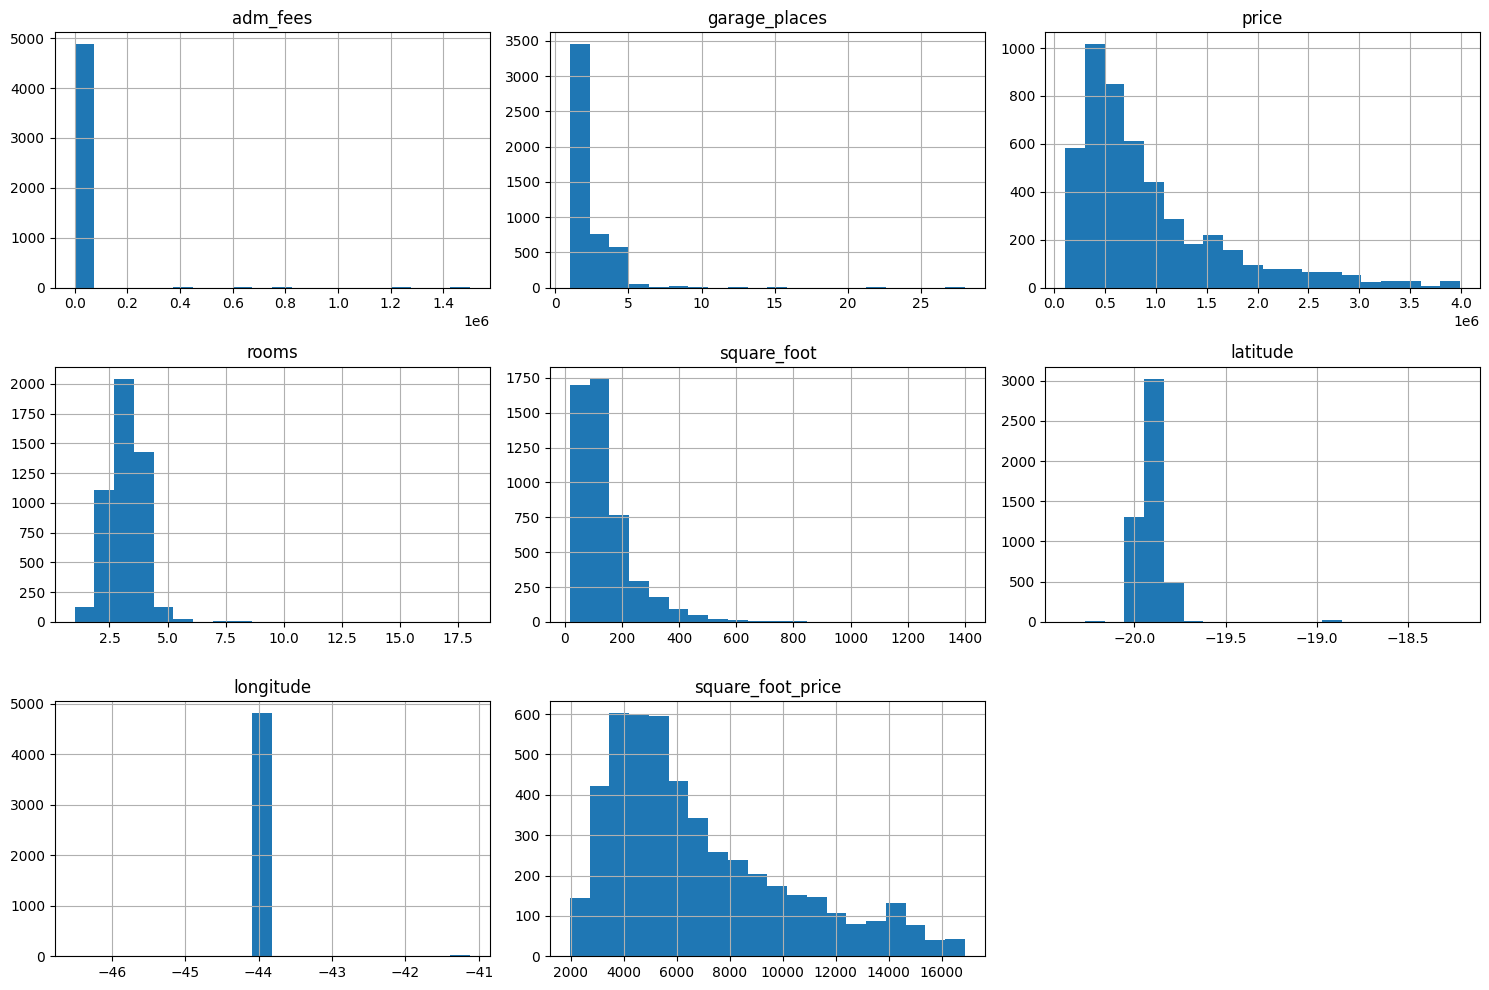

In [14]:
df.hist(bins=20, figsize=(15, 10))
plt.tight_layout()

<Axes: xlabel='longitude', ylabel='price'>

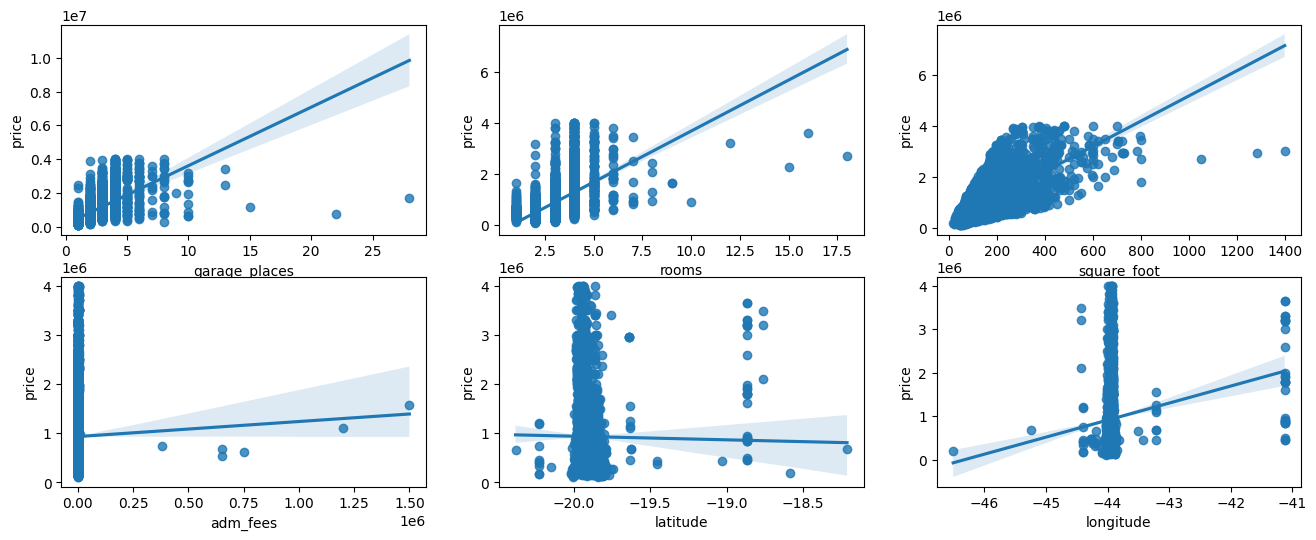

In [15]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(16, 6))

sns.regplot(x='garage_places', y='price', data=df, scatter=True, fit_reg=True, ax=ax1)
sns.regplot(x='rooms', y='price', data=df, scatter=True, fit_reg=True, ax=ax2)
sns.regplot(x='square_foot', y='price', data=df, scatter=True, fit_reg=True, ax=ax3)
sns.regplot(x='adm_fees', y='price', data=df, scatter=True, fit_reg=True, ax=ax4)
sns.regplot(x='latitude', y='price', data=df, scatter=True, fit_reg=True, ax=ax5)
sns.regplot(x='longitude', y='price', data=df, scatter=True, fit_reg=True, ax=ax6)

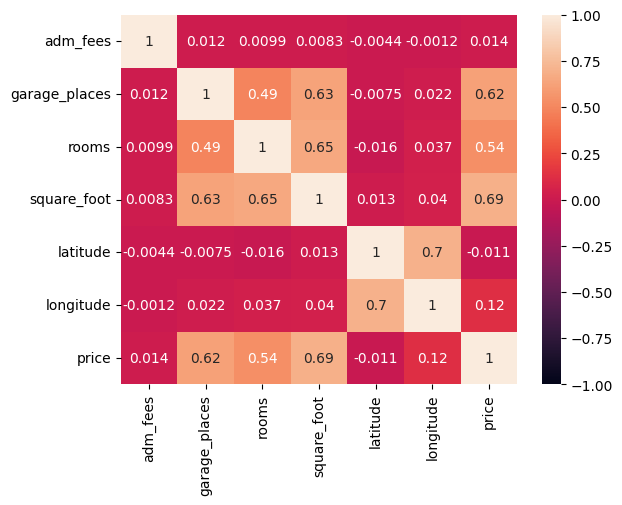

In [16]:
corr = df[num_features + [target_variable]].corr()
corr.style.background_gradient(cmap='coolwarm')

sns.heatmap(corr, vmin=-1, vmax=1, annot=True);

From this analysis, we can deduct the following information:

- Except for a few outliers, the columns `latitude` and `longitude` are very concentrated around their centers. Since those variables are likely to be correlated with the `neighborhood` variable which might contain more information, we'll keep it simple for now and leave them outside our model.
- The `adm_fees` variable have some extremely high outliers. We could filter them but, since a lot of properties have an `admin_fee` of zero might explain the low correlation and make this variable difficult to use.
- `garage_places`, `rooms` and `square_foot` all seem interesting for our model. However, we'll trim some outliers and try to increase the correlation. Let's remove the properties with an area over 700 or with more than 6 rooms and gara places.

This last point goes in the direction of limiting our model to more classic estates since `mansions` probably have a very different pricing strategy.

In [17]:
df_wh_outliers = df[(df.rooms <= 6) & (df.garage_places <= 6) &  (df.square_foot <= 700)]
print(f'{len(df)-len(df_wh_outliers)} properties where removed from the dataset.')

68 properties where removed from the dataset.


<Axes: xlabel='square_foot', ylabel='price'>

<Figure size 640x480 with 0 Axes>

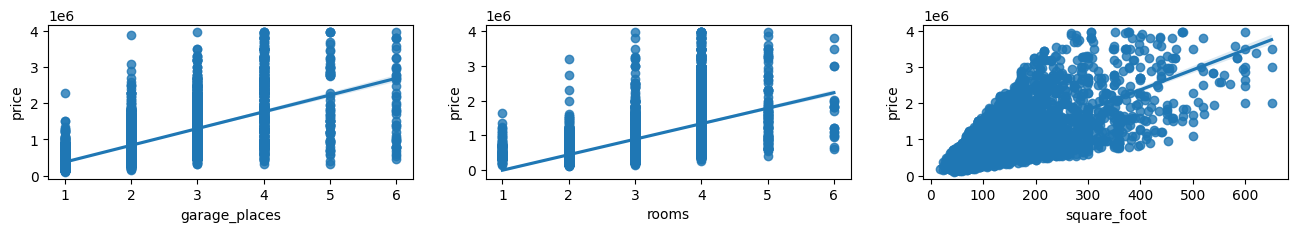

In [18]:
num_features = ['garage_places', 'rooms', 'square_foot']

plt.tight_layout()
fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, figsize=(16, 2))

sns.regplot(x='garage_places', y='price', data=df_wh_outliers, scatter=True, fit_reg=True, ax=ax1)
sns.regplot(x='rooms', y='price', data=df_wh_outliers, scatter=True, fit_reg=True, ax=ax2)
sns.regplot(x='square_foot', y='price', data=df_wh_outliers, scatter=True, fit_reg=True, ax=ax3)

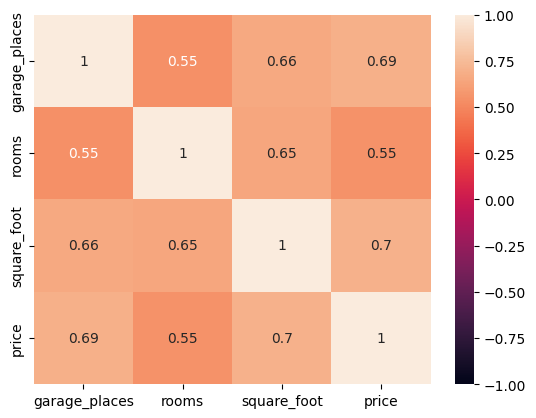

In [19]:
corr = df_wh_outliers[num_features + [target_variable]].corr()
corr.style.background_gradient(cmap='coolwarm')

sns.heatmap(corr, vmin=-1, vmax=1, annot=True);

As we can see, removing thos properties from the dataset slowly improved the correlation of our 3 numerical variables with the target.

### Categorical variables
The datasets offers 2 categorical variables: `city` and `neighborhood`. Let's have a look at the distribution of those values.

neighborhood
Buritis              455
Lourdes              311
Serra                219
Sagrada Família      217
Sion                 200
                    ... 
Etelvina Carneiro      1
Granja De Freitas      1
Olaria                 1
Glória                 1
Petrópolis             1
Name: count, Length: 197, dtype: int64
neighborhood
Buritis              455
Lourdes              311
Serra                219
Sagrada Família      217
Sion                 200
                    ... 
Etelvina Carneiro      1
Granja De Freitas      1
Olaria                 1
Glória                 1
Petrópolis             1
Name: count, Length: 197, dtype: int64


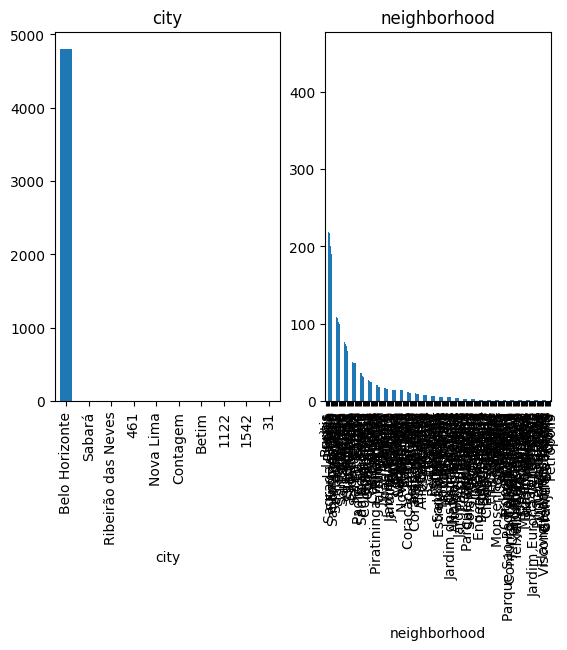

In [20]:
categorical_features = ['city', 'neighborhood']

fig, ax = plt.subplots(1, len(categorical_features))
for i, categorical_feature in enumerate(df_wh_outliers[categorical_features]):
    df_wh_outliers[categorical_feature].value_counts().plot(kind='bar', ax=ax[i]).set_title(categorical_feature)
    print(df_wh_outliers['neighborhood'].value_counts())

We can immediatly see that the `city` mostly contains the value of `Belo Horizonte` which makes sense since the dataset was scrapped for this city. As a result, we will not use it.

The `neighborhood` variable is way more diverse, even though we can see a huge disparity in the representation of the different values. Let see if we can find some correlation between the neighborhood and the price, ordering our scatter plot by the median value of the properties each neighboorhod.

<Axes: xlabel='neighborhood', ylabel='price'>

<Figure size 640x480 with 0 Axes>

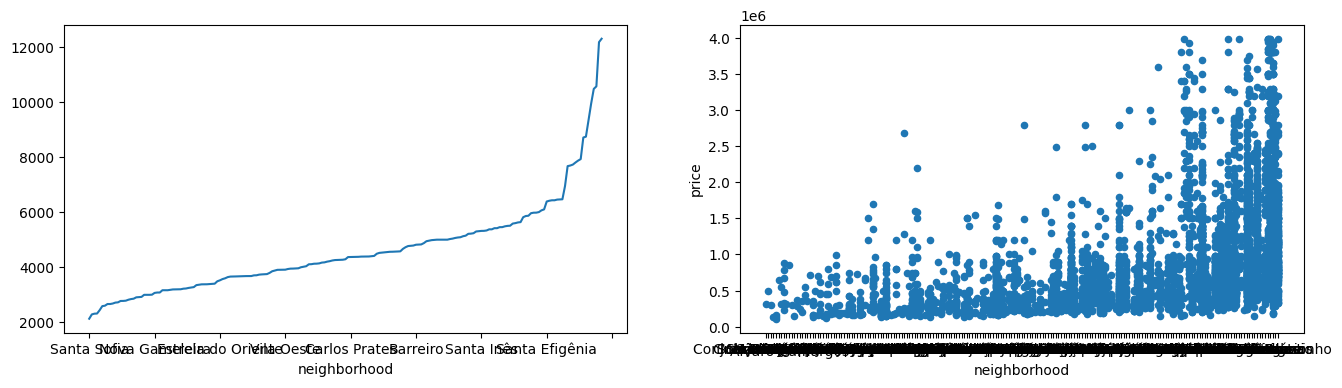

In [21]:
df_neighborhood = df_wh_outliers[['neighborhood', 'square_foot_price']]
df_neighborhood = df_neighborhood.groupby('neighborhood').median()
df_neighborhood.sort_values('square_foot_price', ascending=True, inplace=True)

plt.tight_layout()
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
df_neighborhood['square_foot_price'].plot(ax=ax1)
df.sort_values(by='neighborhood', key=lambda column: column.map(lambda e: list(df_neighborhood.index).index(e))).plot.scatter(x='neighborhood', y='price', ax=ax2)


As we can see, some neigborhoods are clearly more expensive than others. We will then use this variable in our model.